# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться _определять рыночную стоимость объектов недвижимости_.

🎯 _Задача — установить параметры_. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных:
* первые вписаны пользователем
* вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Changelog

### 04.10.2019

- Добавлена ячейка с выводом дублирующихся названий населенных пунктов
- Пропуски в названиях населенных пунктов оставлены нетронутыми на этапе предобработки данных
- Для `ceiling_height`
    - обновлен "ящик с усами" (показаны 25% значений)
    - добавлен комментарий по поводу ошибок
    - установлено минимальное значение в 2.4 м (допустимое нормами строительства)
- При анализе `living_area` используется круговые диаграммы для наглядного представления долей
- EDA:
    - Более адеватный анализ с учетом ошибок и выбросов (в том числе по высоте потолков)
    - Добавлены гистограммы и заметки
    - Исправлены выводы по факторам, влияющим на стоимость недвижимости
- Исправлены общие выводы

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

realty = pd.read_csv('data.csv')

In [2]:
realty.head()

,total_images last_price total_area first_day_exposition rooms ceiling_height floors_total living_area floor is_apartment studio open_plan kitchen_area balcony locality_name airports_nearest cityCenters_nearest parks_around3000 parks_nearest ponds_around3000 ponds_nearest days_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...
3,0\t64900000.0\t159.0\t2015-07-24T00:00:00\t3\t...
4,2\t10000000.0\t100.0\t2018-06-19T00:00:00\t2\t...


❗️ Видим одну колонку, в которой фактические признаки разделены символом табуляции `\t` – прочитаем файл, указав этот разделитель.

In [3]:
realty = pd.read_csv('data.csv', sep='\t')
realty.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Получили 22 признака:

| Название признака    | Описание                                                         |
|----------------------|------------------------------------------------------------------|
| airports_nearest     | расстояние до ближайшего аэропорта в метрах (м)                  |
| balcony              | число балконов                                                   |
| ceiling_height       | высота потолков (м)                                              |
| cityCenters_nearest  | расстояние до центра города (м)                                  |
| days_exposition      | сколько дней было размещено объявление (от публикации до снятия) |
| first_day_exposition | дата публикации                                                  |
| floor                | этаж                                                             |
| floors_total         | всего этажей в доме                                              |
| is_apartment         | апартаменты (булев тип)                                          |
| kitchen_area         | площадь кухни в квадратных метрах (м²)                           |
| last_price           | цена на момент снятия с публикации                               |
| living_area          | жилая площадь в квадратных метрах(м²)                            |
| locality_name        | название населённого пункта                                      |
| open_plan            | свободная планировка (булев тип)                                 |
| parks_around3000     | число парков в радиусе 3 км                                      |
| parks_nearest        | расстояние до ближайшего парка (м)                               |
| ponds_around3000     | число водоёмов в радиусе 3 км                                    |
| ponds_nearest        | расстояние до ближайшего водоёма (м)                             |
| rooms                | число комнат                                                     |
| studio               | квартира-студия (булев тип)                                      |
| total_area           | площадь квартиры в квадратных метрах (м²)                        |
| total_images         | число фотографий квартиры в объявлении                           |

Теперь выведем общую информацию о датафрейме и посмотрим на типы данных.

In [4]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

23 699 записей.

### Проверим наличие дубликатов

In [5]:
# названия населенных пунктов – вдруг есть разные написания
localities = realty['locality_name'].sort_values().unique()

In [6]:
localities

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

⚠️ Помимо `е` и `ё` в слове `поселок` в списке видим населенные пункты, которые изменили свой статус:
* `поселок Мурино` и `Мурино`
* `деревня Кудрово` и `Кудрово`

P.S. Для удобства мы могли бы перенести тип населенного пункта в самостоятельный признак, но пока ограничимся только перечисленными правками на этапе предобработки данных. К тому же, мы не знаем есть ли населенные пункты с одинаковыми названиями. Поэтому такой вариант видится на данный момент оптимальным.

In [7]:
# дубликаты по всем признакам
realty.duplicated().sum()

0

### ...и пропусков

In [8]:
realty.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Вывод

1. Явных дубликатов в данных нет. Нужно будет проверить еще раз на этапе заполнения пропусков и после него 💡

2. В названиях населенных пунктов встречается разное написание слова `поселок` – с `е` и `ё`. Приведем слова к единому написанию.

3. Пропусков хоть отбавляй, особенно для признака `апартаменты`.

    ☝🏻 Но, для проведения анализа данных и построения выводов нам НЕ понадобятся перечисленые ниже признаки. Пропуски и проблемы с типами в них мы можем проигнорировать.

    `is_apartment` (20 924) – с апартаментами все сложно. Само понятие `апартаменты` довольно размытое. Гoвopя ycлoвнo, _aпapтaмeнты — нeжилыe пoмeщeния, в кoтopыx coздaны ycлoвия для пpoживaния_. 
    
    Пропусков в количестве парков/водоемов почти в 3 раза меньше, чем пропусков в признаке расстояния до ближайшего парка/водоема. То ли пользователи приукрашивают объеты недвижимости, то ли есть расхождения в понятиях. Например, является ли водоемом озеро в деревне или лес рядом с поселком? Встает вопрос: кому же доверять – значениям на основе картографических данных (актуальные ли они? нет ли ошибки?), или данным, которые вводит продавец? Как говорил Dr.House – "Everybody lies".

4. Для следующих же признаков необходимо преобразование типов:

| Признак          | Исходный тип | Необходимый тип | Причина замены                                       |
|------------------|--------------|-----------------|------------------------------------------------|
| balcony          | float64      | int64           | Число балконов должно быть целым                   |
| floors_total     | float64      | int64           | Всего этажей в доме не может быть вещественным числом |
| days_exposition  | float64      | int64           | Количество дней публикации – целое число             |

5. `first_day_exposition` представляет собой дату публикации объявления. Для нее мы бы отбросим время приведя столбец к формату `%Y-%m-%d`.

## Шаг 2. Предобработка данных

### Изучим и заполним по возможноси пропущенные значения

✔ 1. `floors_total` – всего этажей в доме. Можно предположить, что это одноэтажные дома. Заполним пропуски значением `1`. Даже если наше предположение ошибочно, 86 записей не должны сильно сдвинуть распределение.

In [9]:
realty['floors_total'] = realty['floors_total'].fillna(1)

✔️ 2. `balcony` – число балконов. Примерно половина записей содержит пропуски. Вполне вероятно, что у недвижимости просто нет балконов. К слову, лоджия – это уже часть жилого помещения. Заполним пропуски `0`.

In [10]:
realty['balcony'] = realty['balcony'].fillna(0)

✔️ 3. `locality_name` – название населенного пункта. Всего 49 пропусков – оставим их для следующего этапа. Хорошо было бы дать фидбек разработчикам портала Недвижимости, чтобы они сделали название населенного пункта обязательным. Продажа объекта _in the middle of nowhere_ – сомнительное занятие.

Выше мы уже выделили список названий всех населенных пунктов и сохранили в переменную `localities`.

In [11]:
len(localities)

365

Сделаем необходимые замены для того, чтобы исключить дубликаты.

In [12]:
def normalize_locality_name(value):
    if str(value) == 'nan':
        return
    
    localities = ['Мурино', 'Кудрово']
    words = value.split(' ')
    
    if words[0] == 'посёлок':
        words[0] = 'поселок'
    
    for locality in localities:
        if locality in words:
            return locality
        
    return ' '.join(words)

In [13]:
realty['locality_name'] = realty['locality_name'].apply(normalize_locality_name)

In [14]:
realty['locality_name'].value_counts()

Санкт-Петербург                               15721
Мурино                                          590
Кудрово                                         472
поселок Шушары                                  440
Всеволожск                                      398
Пушкин                                          369
Колпино                                         338
поселок Парголово                               327
Гатчина                                         307
Выборг                                          237
Петергоф                                        201
Сестрорецк                                      183
Красное Село                                    178
деревня Новое Девяткино                         144
Сертолово                                       142
Ломоносов                                       133
Кириши                                          125
поселок Бугры                                   114
Сланцы                                          112
Волхов      

📝 _Таким образом, в нашем датасете участвуют `329` населенных пунктов. Большая часть объявлений приходится на Петербург и другие города._

✔️ 4. `ceiling_height` (9 195) – высота потолков (м). Пользователи явно не любят вставать на стремянку и делать замеры. В среднем, этот параметр должен колебаться в пределах _2.4 - 3.2 м_. Минимальная высота потолка определяется строительными нормами и правилами как 2.5 м. На этапе EDA детальнее изучим данные и при необходимости почистим их.

✔️ 5. `living_area` (1 903) – нас больше интересует общая площадь квартиры в квадратных метрах (м²).

🚫Заполнить пропуски медианой – не совсем правильное решение, т.к. медиана может быть больше общей площади квартиры.

Проверим не являются ли пропуски характерными для апартаментов или студий, где жилая площадь не так очевидна или пользователи просто не добавили данные.

In [15]:
missing_living_area = realty[realty['living_area'].isnull()]

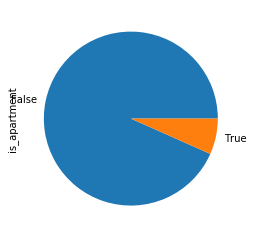

In [16]:
missing_living_area['is_apartment'].value_counts().plot(kind='pie')
plt.show()

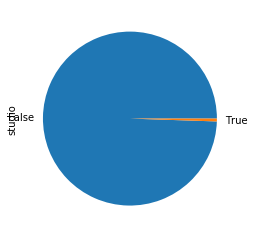

In [17]:
missing_living_area['studio'].value_counts().plot(kind='pie')
plt.show()

In [18]:
# Непохоже...заполняем медианой
realty.loc[realty['living_area'].isnull(), 'living_area'] = realty['living_area'].median()

✔️ 6. `days_exposition` (3 181) – сколько дней было размещено объявление (от публикации до снятия). На эти пропуски мы могли бы указать разработчикам портала недвижимости, ведь дата публикации есть у всех записей, и они явно могут определить, когда объявление было снято с публикации. Для восстановления пропусков у нас нет подходящего признака, поэтому заполним их опять медианой. Проверим распределение на этапе EDA.

In [19]:
realty.loc[realty['days_exposition'].isnull(), 'days_exposition'] = realty['days_exposition'].median()

✔️ 7. `first_day_exposition` приведем к к формату `%Y-%m-%d`:

In [20]:
realty['first_day_exposition'] = pd.to_datetime(realty['first_day_exposition'], format='%Y-%m-%d')

✔️ 8. Часть пропусков признаков *расстояние до x* `airports_nearest` (5 542), `cityCenters_nearest` (5 519) попробуем заполнить медианой по срезу данных по населенному пункту. Но как мы видим, для некоторых записей восстановить пропуски мы не сможем. В этих случаях, скорее всего, пропуски появляются в населенных пунктах, которые не являются городами или прилично удалены от административных центров. Либо же нет картографических данных для рассчета расстояний.

In [21]:
median_data = realty.pivot_table(
    index='locality_name',
    values=['airports_nearest', 'cityCenters_nearest'],
    aggfunc='median'
)

In [22]:
median_data

,airports_nearest,cityCenters_nearest
locality_name,,
Зеленогорск,72282.0,53381.0
Колпино,26232.0,32018.0
Красное Село,25715.5,29140.5
Кронштадт,67850.0,49575.0
Ломоносов,48415.5,51677.0
Мурино,51553.0,21888.0
Павловск,20529.5,32683.0
Петергоф,39231.0,33771.0
Пушкин,15766.0,27930.5


In [23]:
median_data_localities = list(median_data.index)

In [24]:
def fill_missing_data(row, col):
    locality = row['locality_name']
    
    if locality in median_data_localities:
        return median_data.loc[locality][col]
    
    return row[col]

In [25]:
columns = ['airports_nearest', 'cityCenters_nearest']

for column in columns:
    realty.loc[realty[column].isnull(), column] = realty.apply(fill_missing_data, axis=1, args=(column,))

In [26]:
# Проверим данные по скольким населенные пунктам не удалось заполнить
len(realty[realty['cityCenters_nearest'].isnull()]['locality_name'].unique())

303

---
После заполнения пропусков проверим еще раз дубликаты.

In [27]:
realty.duplicated().sum()

0

### Приведение данных к нужным типам

In [28]:
# float63 -> int64
for column in ['balcony', 'floors_total', 'days_exposition']:
    realty[column] = realty[column].astype('int')

## Шаг 3. Посчитаем и добавим в таблицу

### 1. Цену квадратного метра

In [29]:
realty['price_square_meter'] = realty['last_price'] / realty['total_area']

### 2. День недели, месяц и год публикации объявления

In [30]:
realty['day_exposition'] = realty['first_day_exposition'].dt.dayofweek
realty['month_exposition'] = realty['first_day_exposition'].dt.month
realty['year_exposition'] = realty['first_day_exposition'].dt.year

In [31]:
realty.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,...,16028.0,1.0,482.0,2.0,755.0,95,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,...,18603.0,0.0,NaN,0.0,NaN,81,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,...,13933.0,1.0,90.0,2.0,574.0,558,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,30.0,9,NaN,...,6800.0,2.0,84.0,3.0,234.0,424,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,...,8098.0,2.0,112.0,1.0,48.0,121,100000.000000,1,6,2018


### 3. Этаж квартиры

In [32]:
def categorize_floor(row):
    """Категоризация этажей"""

    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
    
realty.loc[:, 'floor'] = realty.apply(categorize_floor, axis=1)

In [33]:
realty['floor'].value_counts()

другой       17446
последний     3336
первый        2917
Name: floor, dtype: int64

### 4. Соотношение жилой и общей площади

In [34]:
# Помним, что мы не заполняли пропуски у признака жилой площади, поэтому данный признак будет тоже содержать пропуски.
realty['living_total_areas_ration'] = realty['living_area'] / realty['total_area']

### 5. Соотношение площади кухни к общей

In [35]:
realty['kitchen_total_areas_ration'] = realty['kitchen_area'] / realty['total_area']

In [36]:
realty.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition,living_total_areas_ration,kitchen_total_areas_ration
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,другой,NaN,...,482.0,2.0,755.0,95,120370.370370,3,3,2019,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,первый,NaN,...,NaN,0.0,NaN,81,82920.792079,1,12,2018,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.3,другой,NaN,...,90.0,2.0,574.0,558,92785.714286,3,8,2015,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,30.0,другой,NaN,...,84.0,3.0,234.0,424,408176.100629,4,7,2015,0.188679,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,другой,NaN,...,112.0,1.0,48.0,121,100000.000000,1,6,2018,0.320000,0.410000


## Шаг 4. Исследовательский анализ данных

💡 Следим за выбросами и ищем странности в распределении.

### Площадь

In [37]:
realty['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

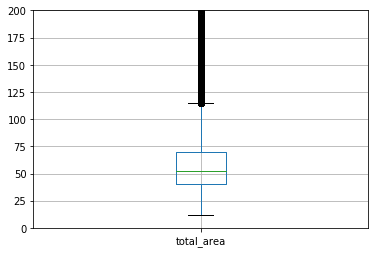

In [38]:
plt.ylim(0, 200)
realty.boxplot('total_area')
plt.show()

* Большая часть значений лежит в диапазоне до 70 кв.м., что выглядит правдаподобно.
* Первый квартиль находится на уровне 40 кв.м.
* Нижний "ус" упирается в 12, минимальное значение. Да, на самом деле есть коморки 12 кв.м.
* Верхний ус заканчивается около 115 кв.м.
* Все, что лежит за ориентировочной границей нормального размаха, считаем выбросом.

📝 _Таким образом, нам нужен будет следующией диапазон значений: 12 – 115 кв.м._

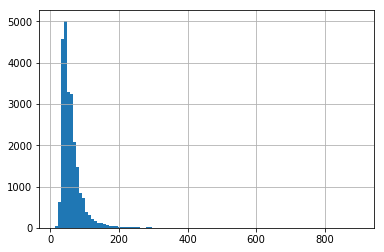

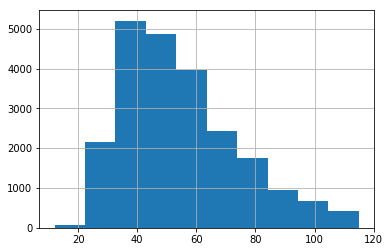

In [39]:
# Грязные данные
realty['total_area'].hist(bins=100)
plt.show()
# Данные без выбросов и ошибок
realty.query('total_area >= 12 and total_area <= 115')['total_area'].hist()
plt.show()

### Цена

Мы ожидаем, что цена будет сильно отличаться в зависимости от населенного пункта. В Санкт-Петербурге в среднем должно быть самое дорогое жилье, а в деревнях и поселках – намного дешевле.

In [40]:
realty['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

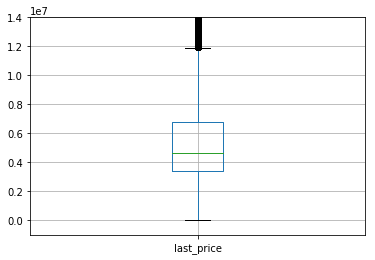

In [41]:
plt.ylim(-1e+06, 1.4e+07)
realty.boxplot('last_price')
plt.show()

* Большая часть значений лежит в диапазоне до 7 млн., что выглядит правдаподобно.
* Первый квартиль на уровне 3.4 млн.
* Нижний "ус" упирается в `0` ⚠️ Минимум равен `12 190`, в то время как средняя стоимость недвижимости – 6.5 млн. 😲 Это выглядит подозрительным. Взглянем на подобные записи.

In [42]:
cheap_realty = realty.query('last_price < 4.5e+5')
cheap_realty.sort_values('last_price').head()[['locality_name', 'last_price', 'total_area']]

,locality_name,last_price,total_area
8793,Санкт-Петербург,12190.0,109.0
14911,поселок станции Свирь,430000.0,54.0
17456,Сланцы,430000.0,30.4
16274,деревня Старополье,440000.0,40.0


Санкт-Петербург! 109 кв.м.! 2 комнаты! всего 12 190 руб. Надо брать! 🤑

Видим ошибку в данных!

📝 _Отменим нижнюю границу для чистых данных в 430 000 тыс._

Смоимость в полмиллиона для деревней выглядит правдивой.

Согласно диаграмме размаха, верхний ус заканчивается около `12 000 000`. Данные выше этого значения считаются выбросами. С другой стороны, есть много ну очень дорогой недвижимости, запредельная стоимость которой, является правдоподобной.

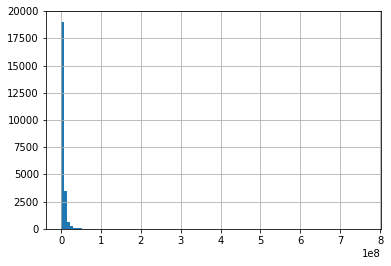

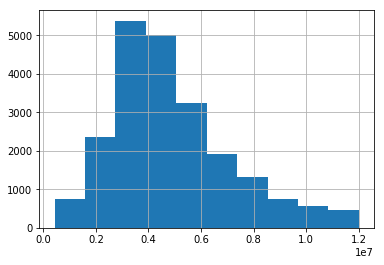

In [43]:
# Грязные данные
realty['last_price'].hist(bins=100)
plt.show()
# Данные без выбросов и ошибок
realty.query('last_price >= 4.3e+5 and last_price <= 1.2e+7')['last_price'].hist()
plt.show()

### Число комнат

In [44]:
realty['rooms'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

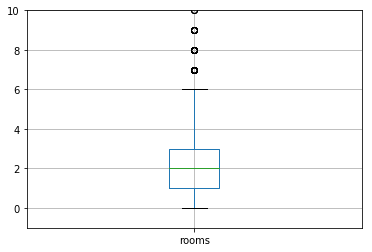

In [45]:
plt.ylim(-1, 10)
realty.boxplot('rooms')
plt.show()

* Большая часть значений лежит в диапазоне до 3х комнат, что выглядит правдаподобно.
* Первый квартиль находится на уровне 1 комнаты.
* Нижний "ус" упирается в 0, минимальное значение. ⚠️Считаем за ошибку в данных.
* Верхний ус заканчивается около 6.
* Выбросы лежат за ориентировочной границей нормального распределения.

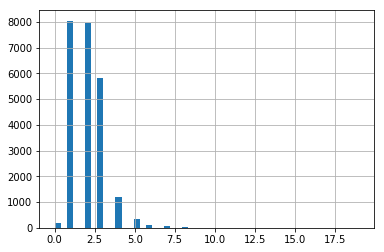

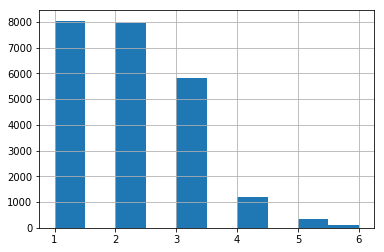

In [46]:
# Грязные данные
realty['rooms'].hist(bins=50)
plt.show()
# Данные без выбросов и ошибок
realty.query('rooms >= 1 and rooms <= 6')['rooms'].hist()
plt.show()

📝 _В ходу, как обычно, однушки, двушки и трешки._

### Высота потолков

In [47]:
realty['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

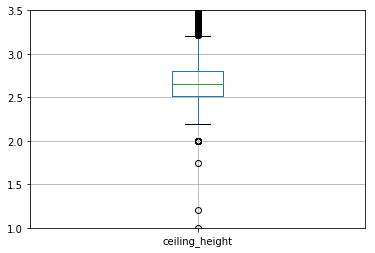

In [48]:
plt.ylim(1, 3.5)
realty.boxplot('ceiling_height')
plt.show()

* Большая часть значений лежит в диапазоне до 2.8 м комнат, что выглядит правдаподобно.
* Первый квартиль находится на уровне 2.5 м.
* Нижний "ус" упирается в 2.2 м ⚠️
* Верхний ус заканчивается около 3.2 м.

В среднем, параметр высоты потолков должен колебаться в пределах 2.4 - 3.2 м. Минимальная высота потолка определяется строительными нормами и правилами обычно как 2.5 м.

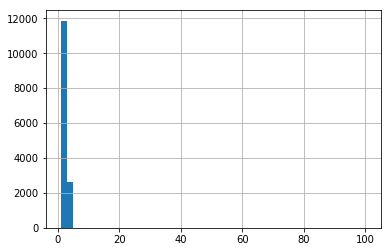

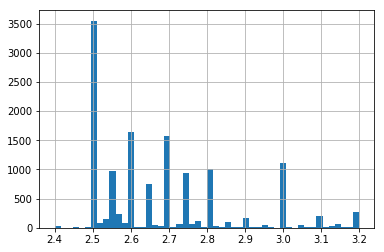

In [49]:
# Грязные данные
realty['ceiling_height'].hist(bins=50)
plt.show()
# Данные без выбросов и ошибок
realty.query('ceiling_height >= 2.4 and ceiling_height <= 3.2')['ceiling_height'].hist(bins=50)
plt.show()

### Время продажи

In [50]:
realty['days_exposition'].describe()

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

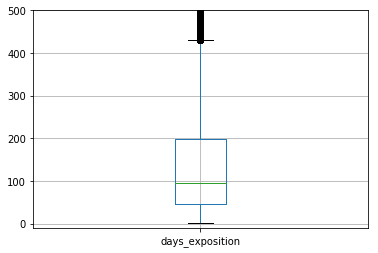

In [51]:
plt.ylim(-10, 500)
realty.boxplot(column='days_exposition')
plt.show()

* Большая часть значений лежит в диапазоне до 200 дней, что выглядит правдоподобно. Продать квартиру – дело небыстрое.
* Первый квартиль лежит на уровне 45 дней.
* Нижний ус упирается в 1, минимальное значение. ⚠️
* Верхний заканчивается в около 430 дней.

📝 Таким образом:
* продажа обычно занимает около 100 дней;
* если объект продан в течение 50 дней – это необычайно быстро; также есть вероятность, что собственник передумал продавать квартиру и снял объявление с публикации. Стоит ли отсекать такие значения – вопрос, наверное, к product owner. Будем рассматривать временной промежуток от недели.
* если в диапазоне от 200 дней – необычайно долго.

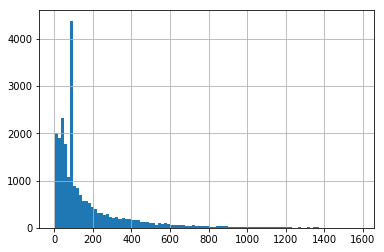

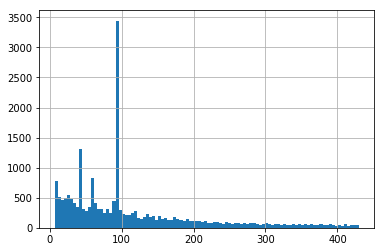

In [52]:
# Грязные данные
realty['days_exposition'].hist(bins=100)
plt.show()
# Данные без выбросов и ошибок
realty.query('days_exposition >= 7 and days_exposition <= 430')['days_exposition'].hist(bins=100)
plt.show()

### Изучим факторы, влияющие на стоимость недвижимости

Факторы будем рассматривать в контексте данных, прошедших очистку на предыдущих этапах. Для срезов у нас будут следующие условия:

In [53]:
total_area_query = 'total_area >= 12 and total_area <= 115'
last_price_query = 'last_price >= 4.3e+5 and last_price <= 1.2e+7'
rooms_query = 'rooms >= 1 and rooms <= 6'
ceiling_height_query = 'ceiling_height >= 2.4 and ceiling_height <= 3.2'
days_exposition_query = 'days_exposition >= 7 and days_exposition <= 430'

#### Зависимость стоимости недвижимости от цены квадратного метра

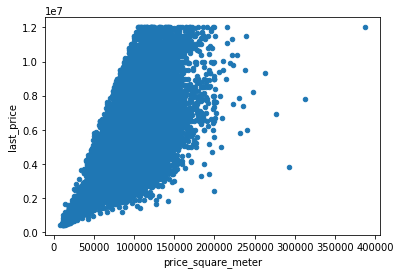

In [54]:
clean_data_query = f'{total_area_query} and {last_price_query}'
clean_data = realty.query(clean_data_query)

clean_data.plot(x='price_square_meter', y='last_price', kind='scatter')
plt.show()

In [55]:
clean_data['price_square_meter'].corr(clean_data['last_price'])

0.6312384710845483

📝 По графикам и коэффициенту корреляции видим, что взаимосвязь между изменением цены за квадратный метр и стоимостью недвижимости (ее ростом) есть, и она не такая уж и слабая.

#### Зависимость стоимости недвижимости от числа комнат

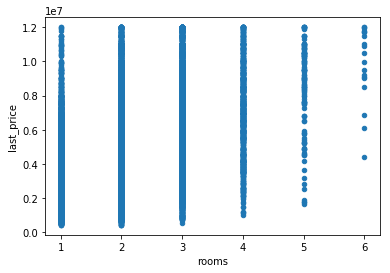

In [56]:
clean_data_query = f'{rooms_query} and {last_price_query}'
clean_data = realty.query(clean_data_query)

clean_data.plot(x='rooms', y='last_price', kind='scatter')
plt.show()

In [57]:
clean_data['rooms'].corr(clean_data['last_price'])

0.45206215582459547

📝 Корреляция и график иллюстрируют слабую завимисоть между количеством комнат и стоимостью недвижимости.

#### Зависимость стоимости недвижимости от этажа

In [58]:
realty[['floor', 'last_price']].query(last_price_query).pivot_table(index='floor', values='last_price')

,last_price
floor,
другой,5.072145e+06
первый,4.160474e+06
последний,4.533718e+06


📝 Первый этаж – самый дешевый, на последнем этаже любям селиться не все, а этажи между, как правило, самые популярные.

#### Зависимость стоимости недвижимости от расстояние до центра города (м)

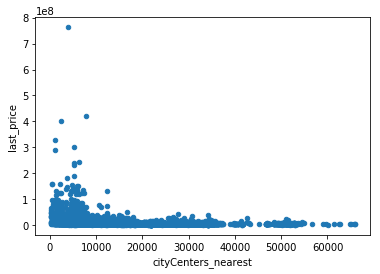

In [59]:
clean_data = realty.query(last_price_query)
realty.plot(x='cityCenters_nearest', y='last_price', kind='scatter')
plt.show()

In [60]:
clean_data['cityCenters_nearest'].corr(clean_data['last_price'])

-0.3646086230729808

📝 По коэффициенту Пирсона видим, что так же есть слабая взаимосвязь между расстоянием от центра и ценой – к цетру дороже. Большинство объектов недвижимости так или иначе недалеко от центра. Основная часть дорогих объектов ожидаемо ближе к центру.

#### Зависимость стоимости недвижимости от даты публикации объявления

In [61]:
clean_data = realty.query(f'{days_exposition_query} and {last_price_query}')

In [62]:
clean_data[['day_exposition', 'month_exposition', 'year_exposition', 'last_price']].corr()

,day_exposition,month_exposition,year_exposition,last_price
day_exposition,1.000000,0.010180,-0.013679,-0.012430
month_exposition,0.010180,1.000000,-0.305183,0.004125
year_exposition,-0.013679,-0.305183,1.000000,0.028693
last_price,-0.012430,0.004125,0.028693,1.000000


📝 Связи между днями недели, месяцами, годами публикации и стоимостью недвижимости нет. Коэффициент Пирсона практически равен `0`. Из трех признаков только год чуть-чуть выделяется. К слову, из таблицы корреляции мы видим связь между месяцем и годом.

#### 10 населённых пунктов с наибольшим числом объявлений

In [63]:
top_localities = realty['locality_name'].value_counts().head(10)

In [64]:
top_localities

Санкт-Петербург      15721
Мурино                 590
Кудрово                472
поселок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                307
Выборг                 237
Name: locality_name, dtype: int64

In [65]:
top_locality_names = list(top_localities.index)

In [66]:
(
    realty.query(f'locality_name in @top_locality_names and {last_price_query}')
    .pivot_table(index='locality_name', values='price_square_meter')
    .sort_values(by='price_square_meter', ascending=False)
)

,price_square_meter
locality_name,
Санкт-Петербург,105628.948318
Пушкин,100322.823868
Кудрово,95152.072198
поселок Парголово,90175.913458
Мурино,86087.512050
поселок Шушары,78677.364217
Колпино,75185.478229
Гатчина,68421.902770
Всеволожск,67214.252635


📝 В Санкт-Петербурге квадратный метр самый дорогой – столица, хоть и северная. В Выборге – самый дешевый.

#### Недвижимость в Питере

In [67]:
# Для начала выберем всю недвижимость города
saint_petersburg = pd.DataFrame(realty.loc[realty['locality_name'] == "Санкт-Петербург"])
saint_petersburg.reset_index()
len(saint_petersburg)

15721

🎯 _Выясним, какая область входит в центр._

In [68]:
# Создадим столбец с расстоянием до центра в километрах округляя до целых значений
km = 1_000
saint_petersburg['cityCenters_nearest_km'] = (saint_petersburg['cityCenters_nearest'] / km).astype('int')

Посчитаем среднюю цену для каждого километра удаленности учитывания:

In [69]:
spb_prices = saint_petersburg.query(last_price_query)
spb_prices.pivot_table(index='cityCenters_nearest_km', values='last_price')

,last_price
cityCenters_nearest_km,
0,8.429409e+06
1,8.396685e+06
2,7.721342e+06
3,7.598287e+06
4,7.856875e+06
5,7.446107e+06
6,6.887989e+06
7,6.765614e+06
8,6.353700e+06


Построим график, который показывает как цена зависит от удалённости от центра:

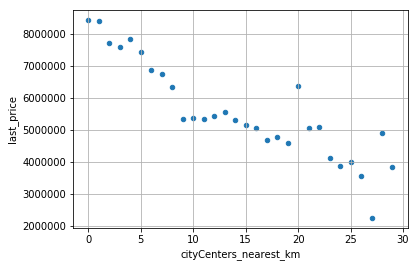

In [70]:
(
    pd.DataFrame(spb_prices.pivot_table(index='cityCenters_nearest_km', values='last_price').to_records())
    .plot(x='cityCenters_nearest_km', y='last_price', kind='scatter', grid=True)
)
plt.show()

📝 Определим границу, где график сильно меняется — это и будет центральная зона. В нашем случае это 7 км.

----

⭐️ Выделим сегмент квартир в центре.

In [71]:
apartments_in_center = pd.DataFrame(spb_prices.query('cityCenters_nearest_km <= 7'))
len(apartments_in_center)

2503

---

**Проанализируем эти `2 503` объектов недвижимости. Для начала изучим параметры.**

In [72]:
# площадь
apartments_in_center.query(total_area_query)['total_area'].describe()

count    2402.000000
mean       64.638318
std        21.137366
min        12.000000
25%        47.100000
50%        63.050000
75%        79.797500
max       115.000000
Name: total_area, dtype: float64

_Средняя площадь 63 кв.м._

In [73]:
# цена
apartments_in_center['last_price'].describe()

count    2.503000e+03
mean     7.502496e+06
std      2.262249e+06
min      1.600000e+06
25%      5.800000e+06
50%      7.400000e+06
75%      9.150000e+06
max      1.200000e+07
Name: last_price, dtype: float64

_Средняя цена 7.5 млн. руб._

In [74]:
# число комнат
apartments_in_center.query(rooms_query)['rooms'].describe()

count    2486.000000
mean        2.376508
std         1.038415
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

_Больше объявлений по двушкам и трешкам._

In [75]:
# высота потолков
apartments_in_center.query(ceiling_height_query)['ceiling_height'].describe()

count    1258.000000
mean        2.876415
std         0.214601
min         2.400000
25%         2.700000
50%         2.900000
75%         3.000000
max         3.200000
Name: ceiling_height, dtype: float64

_Средняя высота потолков ~2.9 м. Нормальные потолки, в общем._

---

**Выделим факторы, влияющие на стоимость квартиры.**

In [76]:
# Ранее мы уже сделали срез по квартирам в центре Питера с учетом границы нормального размаха цены.
# Добавим остальные критерии, влияющие на чистоту данных, и сделаем окончательный срез на их основе.
clean_data_query = f'{total_area_query} and {rooms_query} and {ceiling_height_query} and {days_exposition_query}'
clean_data = apartments_in_center.query(clean_data_query)

In [77]:
features = [
    'last_price',
    'cityCenters_nearest_km',
    'total_area',
    'rooms',
    'ceiling_height',
    'day_exposition',
    'month_exposition',
    'year_exposition'
]

clean_data[features].corr().sort_values('last_price', ascending=False)

,last_price,cityCenters_nearest_km,total_area,rooms,ceiling_height,day_exposition,month_exposition,year_exposition
last_price,1.000000,-0.189474,0.701334,0.471256,0.242488,-0.033625,-0.002980,0.036056
total_area,0.701334,-0.216843,1.000000,0.804875,0.302426,-0.062816,0.018970,-0.069397
rooms,0.471256,-0.189124,0.804875,1.000000,0.229586,-0.047925,0.030974,-0.028015
ceiling_height,0.242488,-0.278038,0.302426,0.229586,1.000000,-0.018873,-0.050992,-0.032137
year_exposition,0.036056,0.066251,-0.069397,-0.028015,-0.032137,0.053896,-0.368342,1.000000
month_exposition,-0.002980,-0.038447,0.018970,0.030974,-0.050992,0.016592,1.000000,-0.368342
day_exposition,-0.033625,0.035337,-0.062816,-0.047925,-0.018873,1.000000,0.016592,0.053896
cityCenters_nearest_km,-0.189474,1.000000,-0.216843,-0.189124,-0.278038,0.035337,-0.038447,0.066251


In [78]:
# этаж
clean_data.pivot_table(index='floor', values='last_price').sort_values(by='last_price')

,last_price
floor,
первый,6.439747e+06
последний,7.367485e+06
другой,7.407854e+06


_Как и в случае с недвижимостью по всем населенным пунктам, в Петербурге все также самый дешевый этаж – это первый, а самые дорогие – между первым и последним._

## Шаг 5. Общий вывод

* Недвижимость в центре Петербурга ожидаемо стоит дороже остальных населенных пунктов.
* Ближе к центру города дороже. Однако в пределах центра стоимость +/- однинаковая.
* Факторы, влияющие на стоимость:
    * общая площадь
    * кол-во комнат
    * высота потолков